In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from great_tables import GT, style, loc, md

In [3]:
files = os.listdir('baseline_merged')
files = [file for file in files if file.endswith('.csv')]

baseline_merged = pd.concat([pd.read_csv(f'baseline_merged/{file}') for file in files])
baseline_merged.dropna(subset='recc_rate', inplace=True)

baseline_merged=baseline_merged[~baseline_merged['User'].isin(['Nathan Worrell','Liam Jagrowski','Henry Cross','Dylan Orr','Jacob Swain','John Hazelton','Brian Dietrich'])]

baseline_merged['InputtedRent'] = baseline_merged['InputtedRent'].str.replace(',','').astype(float)
baseline_merged['RecommendationDate'] = pd.to_datetime(baseline_merged['RecommendationDate'])

AssetDetailActive = pd.read_csv('data/vw_AssetDetailActive.csv')

baseline_merged = baseline_merged.merge(AssetDetailActive, on='AssetName')

baseline_merged['Diff'] = baseline_merged['InputtedRent'] - baseline_merged['recc_rate']

In [4]:
baseline_merged['accepted'] = abs(baseline_merged['InputtedRent'] - baseline_merged['recc_rate']) < 1
baseline_merged['accepted_range'] = (baseline_merged['InputtedRent'] >= baseline_merged['recc_rate_lower']) & (baseline_merged['InputtedRent'] <= baseline_merged['recc_rate_upper'])

rejections = baseline_merged[~baseline_merged['accepted']]
rejections['increase'] = rejections['Diff'] > 0
rejections['decrease'] = rejections['Diff'] < 0

C:\Users\Tyson.King\AppData\Local\Temp\ipykernel_37816\326457472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejections['increase'] = rejections['Diff'] > 0
C:\Users\Tyson.King\AppData\Local\Temp\ipykernel_37816\326457472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejections['decrease'] = rejections['Diff'] < 0


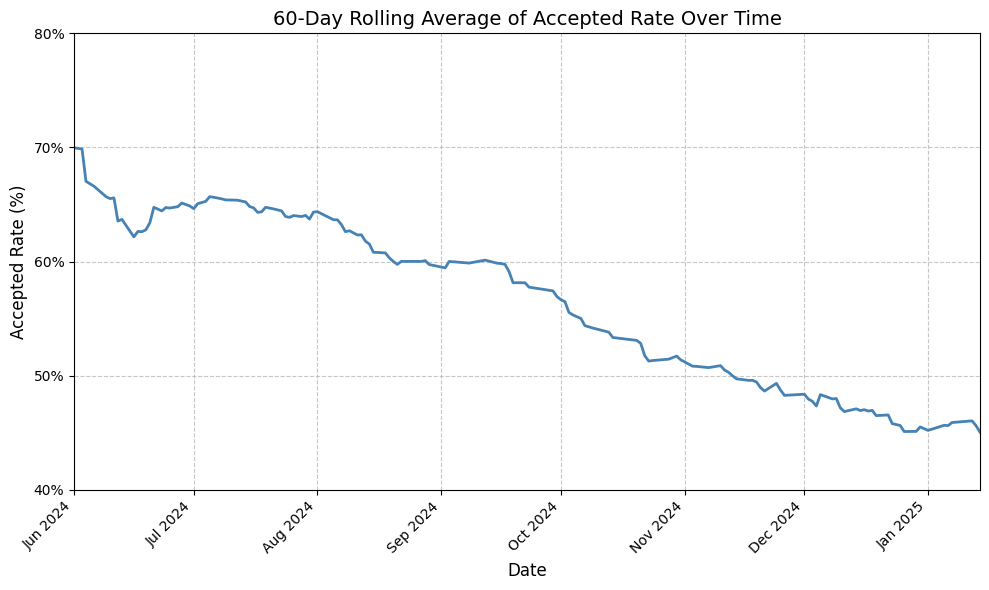

In [5]:
# Calculate daily average of accepted rate
daily_avg = baseline_merged.groupby('RecommendationDate')['accepted_range'].mean()

# Calculate rolling average of accepted rate over time
rolling_avg = daily_avg.rolling(window=60, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_avg, color='steelblue', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accepted Rate (%)', fontsize=12)
plt.title('60-Day Rolling Average of Accepted Rate Over Time', fontsize=14)
plt.xlim(pd.to_datetime('2024-06-01'), max(daily_avg.index))
plt.ylim(0.4, 0.8)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8], ['40%', '50%', '60%', '70%', '80%'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.style.use('seaborn-v0_8-muted')
plt.tight_layout()
plt.show()

In [6]:
accepted_pct = (baseline_merged['accepted_range']).mean()
accepted_pct = round(accepted_pct * 100, 1)

rejected_inc = (rejections['increase']).mean()
rejected_dec = 1 - rejected_inc


rejected_inc = round(rejected_inc * 100, 1)
rejected_dec = round(rejected_dec * 100, 1)

# Print out values for debugging
print(f"Accepted percentage: {accepted_pct}")
print(f"Rejected Increase percentage: {rejected_inc}")
print(f"Rejected Decrease percentage: {rejected_dec}")

Accepted percentage: 52.3
Rejected Increase percentage: 62.3
Rejected Decrease percentage: 37.7


In [9]:
total_adj = len(baseline_merged)

by_reason = baseline_merged.groupby('ChangeReason').agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('count', ascending=False).reset_index()

by_reason['prop'] = by_reason['count'] / total_adj

display(by_reason)

,ChangeReason,count,acceptance_rate,median_adjustment,prop
0,Baseline Rent Accepted,3483,0.844674,0.206242,0.516842
1,Other Action taken (see comment),1242,0.218196,55.193314,0.184300
2,Strong/High trends do not support rent recomme...,1178,0.134975,85.183543,0.174803
3,Soft/Low trends do not support rent recommenda...,398,0.178392,-62.177110,0.059059
4,Low lead conversion,182,0.076923,-58.803515,0.027007
5,Known product issue,73,0.273973,47.662010,0.010832
6,Low lead volume,69,0.333333,12.824892,0.010239
7,Known people issue,58,0.275862,44.791175,0.008607
8,"Cashflow strategy, Elevated occupancy goal v....",32,0.250000,-28.814697,0.004748
9,Change in normal strategy due to dispo,19,0.157895,66.178710,0.002819


In [11]:
# Create a GT object
table = GT(by_reason[['ChangeReason', 'count', 'prop', 'median_adjustment']])

table = (
    table
    .cols_label(ChangeReason = md("**Change Reason**"),
                count = md("**Count**"),
                prop = md("**Proportion**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Selected 'Change Reason'")
    .fmt_currency(columns = 3)
    .fmt_percent(columns = 2)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

GT(_tbl_data=                                         ChangeReason  count      prop  \
0                              Baseline Rent Accepted   3483  0.516842   
1                    Other Action taken (see comment)   1242  0.184300   
2   Strong/High trends do not support rent recomme...   1178  0.174803   
3   Soft/Low trends do not support rent recommenda...    398  0.059059   
4                                 Low lead conversion    182  0.027007   
5                                 Known product issue     73  0.010832   
6                                     Low lead volume     69  0.010239   
7                                  Known people issue     58  0.008607   
8   Cashflow strategy,  Elevated occupancy goal v....     32  0.004748   
9              Change in normal strategy due to dispo     19  0.002819   
10  Known or presumed retention misaligns with pro...      5  0.000742   

    median_adjustment  
0            0.206242  
1           55.193314  
2           85.183543  
3          -62.177110  
4          -58.803515  
5           47.662010  
6           12.824892  
7           44.791175  
8          -28.814697  
9           66.178710  
10          94.458687  , _body=<great_tables._gt_data.Body object at 0x0000013CDBC11750>, _boxhead=Boxhead([ColInfo(var='ChangeReason', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Change Reason**'), column_align='left', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Count**'), column_align='right', column_width=None), ColInfo(var='prop', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Proportion**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000013CDBBDEFD0>, _spanners=Spanners([]), _heading=Heading(title="Price Change Metrics by Selected 'Change Reason'", subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=5, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=6, colnum

In [16]:
example_comments = baseline_merged[baseline_merged['ChangeReason'] == 'Other Action taken (see comment)'].dropna(subset='Comment').sample(15)['Comment']

# Save comments to a text file with one observation per line and no index
with open('figures/example_comments.txt', 'w') as f:
    for comment in example_comments:
        f.write(comment + '\n')

In [ ]:
by_property = baseline_merged.groupby(['AssetName', 'User']).agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

by_property = by_property[by_property['count'] > 20]

# Calculate the overall mean acceptance rate
overall_mean_acceptance_rate = baseline_merged['accepted_range'].mean()

# Function to perform the hypothesis test
def perform_hypothesis_test(asset_name, overall_mean):
    # Get the acceptance rates for the current asset
    asset_data = baseline_merged[baseline_merged['AssetName'] == asset_name]['accepted_range']
    
    # Check if there are enough data points to perform the test
    if len(asset_data) > 1:  # We need at least two data points for a valid t-test
        t_stat, p_value = stats.ttest_1samp(asset_data, overall_mean)
        return p_value
    else:
        return float('nan')  # Return NaN if not enough data to perform t-test


# Apply the hypothesis test for each market and store the results in a new column 'p_value'
by_property['p_value'] = by_property['AssetName'].apply(lambda x: perform_hypothesis_test(x, overall_mean_acceptance_rate))

# Adding a new column 'is_significant' to indicate if p-value is less than 0.05 (95% confidence)
by_property['is_significant'] = by_property['p_value'] < 0.05

by_property = by_property[['AssetName', 'User', 'acceptance_rate', 'median_adjustment', 'count', 'p_value', 'is_significant']]

# Filter markets that are significantly different from the overall mean (p-value < 0.05)
significant_properties = by_property[by_property['is_significant']]

below_average_properties = significant_properties[significant_properties['acceptance_rate'] < overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
below_average_properties = below_average_properties.drop(columns=['count', 'p_value', 'is_significant']).tail(5)

# Create a GT object
table = GT(below_average_properties)

table = (
    table
    .cols_label(AssetName = md("**Property**"),
                User = md("**RM**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Property",
                subtitle = "(Properties with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 3)
    .fmt_percent(columns = 2)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

In [ ]:
baseline_merged['AcquisitionDate_numeric'] = pd.to_datetime(baseline_merged['AcquisitionDate']).astype(int) / 10**9

# Perform the aggregation
by_market = baseline_merged.groupby(['MarketName']).agg(
    count=('accepted', 'count'),
    acceptance_rate=('accepted_range', 'mean'),
    num_assets=('AssetName', 'nunique'),
    acquisition_date_numeric=('AcquisitionDate_numeric', 'min'),
    median_adjustment=('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

# Convert the numeric values back to dates
by_market['acquisition_date'] = pd.to_datetime(by_market['acquisition_date_numeric'], unit='s')
by_market.drop(columns=['acquisition_date_numeric'], inplace=True)

# Function to perform the hypothesis test
def perform_hypothesis_test(market_name, overall_mean):
    # Get the acceptance rates for the current market
    market_data = baseline_merged[baseline_merged['MarketName'] == market_name]['accepted_range']
    
    # Check if there are enough data points to perform the test
    if len(market_data) > 1:  # We need at least two data points for a valid t-test
        t_stat, p_value = stats.ttest_1samp(market_data, overall_mean)
        return p_value
    else:
        return float('nan')  # Return NaN if not enough data to perform t-test

# Apply the hypothesis test for each market and store the results in a new column 'p_value'
by_market['p_value'] = by_market['MarketName'].apply(lambda x: perform_hypothesis_test(x, overall_mean_acceptance_rate))

# Adding a new column 'is_significant' to indicate if p-value is less than 0.05 (95% confidence)
by_market['is_significant'] = by_market['p_value'] < 0.05

by_market = by_market[['MarketName', 'num_assets', 'acquisition_date', 'acceptance_rate', 'median_adjustment', 'count', 'p_value', 'is_significant']]

# Filter markets that are significantly different from the overall mean (p-value < 0.05)
significant_markets = by_market[by_market['is_significant']]

below_average_markets = significant_markets[significant_markets['acceptance_rate'] < overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
below_average_markets = below_average_markets.drop(columns=['count', 'p_value', 'is_significant'])

# Create a GT object
table = GT(below_average_markets)

table = (
    table
    .cols_label(MarketName = md("**Market**"),
                num_assets = md("**# Assets**"),
                acquisition_date = md("**Earliest Acquisition**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market",
                subtitle = "(Markets with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

# Display the table
table.save('figures/low_acc_bymarket.png')


In [ ]:
above_average_markets = significant_markets[significant_markets['acceptance_rate'] > overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
above_average_markets = above_average_markets.drop(columns=['count', 'p_value', 'is_significant'])

# Create a GT object
table = GT(above_average_markets)

table = (
    table
    .cols_label(MarketName = md("**Market**"),
                num_assets = md("**# Assets**"),
                acquisition_date = md("**Earliest Acquisition**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market",
                subtitle = "(Markets with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

# table.save('figures/high_acc_bymarket.png')


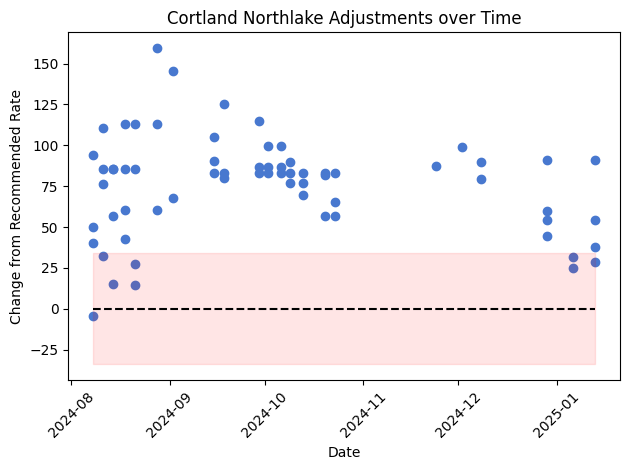

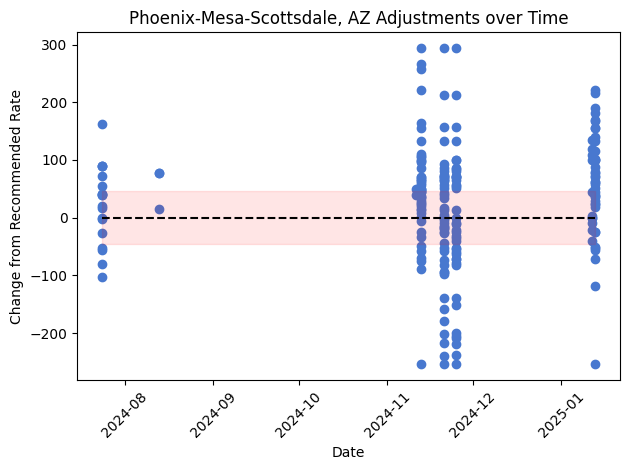

In [8]:
def get_adj_over_time(asset_name=None, market_name=None):

    if asset_name:
        filtered = baseline_merged[baseline_merged['AssetName'] == asset_name]
    elif market_name:
        filtered = baseline_merged[baseline_merged['MarketName'] == market_name]

    filtered = filtered.sort_values('RecommendationDate').reset_index()

    avg_range = (filtered['recc_rate'] - filtered['recc_rate_lower']).mean()

    plt.scatter(filtered['RecommendationDate'], filtered['Diff'])
    plt.xlabel("Date")
    plt.ylabel("Change from Recommended Rate")

    if asset_name:
        plt.title(f"{asset_name} Adjustments over Time")
    elif market_name:
        plt.title(f"{market_name} Adjustments over Time")
    
    plt.fill_between(filtered['RecommendationDate'], -avg_range, avg_range, color='red', alpha=0.1)
    plt.hlines(0, min(filtered['RecommendationDate']), max(filtered['RecommendationDate']), linestyles="dashed", colors="black")
    plt.xticks(rotation=45)
    plt.style.use('seaborn-v0_8-muted')
    plt.tight_layout()
    if asset_name:
        plt.savefig(f'figures/adj_over_time/{asset_name}')
    elif market_name:
        plt.savefig(f'figures/adj_over_time/{market_name}')
    
    plt.show()
    

get_adj_over_time(asset_name="Cortland Northlake")
# get_adj_over_time(asset_name="Cortland 3131")
get_adj_over_time(market_name="Phoenix-Mesa-Scottsdale, AZ")
# get_adj_over_time(market_name="West Palm Beach-Boca Raton-Delray Beach, FL")
# get_adj_over_time(market_name="Denver-Aurora-Lakewood, CO")
# get_adj_over_time(market_name="Colorado Springs, CO")